We will do the following steps in order:

1. Load and normalize the CIFAR10 training and test datasets using torchvision
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data
6. Convert model to ONNX and OpenVINO IR format
7. Evaluate converted model accuracy
8. Optimize model to INT8 precision

### 1. Load and normalize CIFAR10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# define preprocessing steps for model
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

# define data loaders for training and validation
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

# categories used in dataset
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images

c:\Users\eaidova\Anaconda3\envs\py37\lib\site-packages\matplotlib_inline\config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):



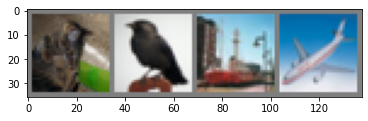

cat   bird  ship  plane


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### 2. Define a Convolutional Neural Network

In [2]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### 3. Define a Loss function and optimizer

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train the network

In [5]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.261
[1,  4000] loss: 1.982
[1,  6000] loss: 1.766
[1,  8000] loss: 1.633
[1, 10000] loss: 1.531
[1, 12000] loss: 1.516
[2,  2000] loss: 1.410
[2,  4000] loss: 1.392
[2,  6000] loss: 1.361
[2,  8000] loss: 1.339
[2, 10000] loss: 1.330
[2, 12000] loss: 1.263
Finished Training


In [6]:
# Save network checkpoint
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### 5. Test the network on the test data

We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

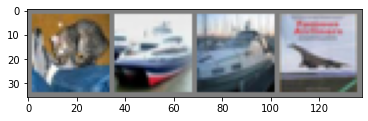

GroundTruth:  cat   ship  ship  plane


In [7]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, let’s load back in our saved model (note: saving and re-loading the model wasn’t necessary here, we only did it to illustrate how to do so):

In [4]:
net = Net()
net.load_state_dict(torch.load('./cifar_net.pth'))

<All keys matched successfully>

now let us see what the neural network thinks these examples above are:

In [9]:
outputs = net(images)

The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy:

In [10]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  plane


Let us look at how the network performs on the whole dataset.

In [11]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 54 %


That looks way better than chance, which is 10% accuracy (randomly picking a class out of 10 classes). Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did not perform well:

In [12]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 71.1 %
Accuracy for class: car   is 60.0 %
Accuracy for class: bird  is 44.3 %
Accuracy for class: cat   is 40.4 %
Accuracy for class: deer  is 43.0 %
Accuracy for class: dog   is 29.8 %
Accuracy for class: frog  is 75.1 %
Accuracy for class: horse is 51.0 %
Accuracy for class: ship  is 67.3 %
Accuracy for class: truck is 60.9 %


### 6. Convert model to ONNX and OpenVINO IR format

We train model and want to run it with OpenVINO framework. For that we need to convert it to IR using OpenVINO Model Optimizer tool. The best practice for PyTorch models to export them to ONNX before starting work.

In [13]:
torch.onnx.export(net, images[0].unsqueeze(0), 'net.onnx')

In [14]:
!mo --input_model net.onnx

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	c:\Users\eaidova\repos\dataset_api\net.onnx
	- Path for generated IR: 	c:\Users\eaidova\repos\dataset_api\.
	- IR output name: 	net
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	Not specified, inherited from the model
	- Source layout: 	Not specified
	- Target layout: 	Not specified
	- Layout: 	Not specified
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	None
	- Reverse input channels: 	False
	- Use legacy API for model processing: 	False
	- Use the transformations config file: 	None
	- OpenVINO runtime found in: 	c:\Users\eaidova\repos\dataset_api\openvino
OpenVINO runt

### 7. Evaluate converted model accuracy

Now we want to check how model works with OpenVINO. We already have dataset and transformation steps defined for PyTorch and need to adopt to work with OpenVINO model.

In [2]:
from openvino.model_zoo.datasets import CIFAR10Dataset # is analog of data loader
from openvino.model_zoo.transforms.input import from_torch # translater for torchvision transforms to openvino

ov_transforms = from_torch(transform) # wrap our torchvision transforms
test_loader = CIFAR10Dataset('./data', reader='pillow_imread')

Annotation conversion for cifar10 dataset has been started
Parameters to be used for conversion:
converter: cifar
data_batch_file: data\cifar-10-batches-py\test_batch
convert_images: True
converted_images_dir: data\test
num_classes: 10
Annotation conversion for cifar10 dataset has been finished


The data_loader has similar to tochvision interface, it allow access to dataset annotation and input data using integer index and iterate over samples. Optional step is appling transformations to input data

The data in iteration represented in following format (batch_idx, batch_annotation), batch_input, batch_metadata, where:

* batch_id - index of selected samples from dataset for data batch
* batch_annotation - batch of labels for selected samples
* batch_input - input data
* batch_metadata - additional dictionary with useful meta for samples (it may contains e.g. info about dataset labels or preprocessing ops history for postprocessing)

let's try visualaze several samples from dataset

In [3]:
batch_idx_batch_annotation, batch_data, batch_meta = test_loader[0]

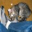

cat


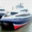

ship


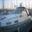

ship


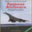

plane


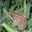

frog


In [4]:
from IPython.display import display
from PIL import Image
for idx, (batch_idx_batch_annotation, batch_input, batch_meta) in enumerate(test_loader):
    display(Image.fromarray(batch_input[0]))
    print(classes[batch_idx_batch_annotation[0][1].label])
    if idx == 4:
        break

Load model and get it predictions

In [3]:
from openvino.runtime import Core
import numpy as np

core = Core()
model = core.read_model('net.xml')
compiled_model = core.compile_model(model, 'CPU')
output = compiled_model.outputs[0]
infer_request = compiled_model.create_infer_request()

In [6]:
test_loader.set_transforms([ov_transforms])
for idx, (batch_idx_batch_annotation, batch_input, batch_meta) in enumerate(test_loader):
    batch_ids, batch_annotations = map(list, zip(*batch_idx_batch_annotation))
    result = next(iter(infer_request.infer([np.array(batch_input)]).values()))
    predicted_label = np.argmax(result[0])
    predicted_score = np.max(result[0])
    print(f'gt class = {classes[batch_annotations[0].label]}, predicted class = {classes[predicted_label]}, predicted score {predicted_score} ')
    if idx == 4:
        break
    

gt class = cat, predicted class = cat, predicted score 1.906031847000122 
gt class = ship, predicted class = ship, predicted score 7.4086480140686035 
gt class = ship, predicted class = ship, predicted score 3.8768107891082764 
gt class = plane, predicted class = plane, predicted score 5.371720790863037 
gt class = frog, predicted class = frog, predicted score 4.307785511016846 


Now lets calculate accuracy of converted network. For accuracy measurement we will use metrics.

In [4]:
from openvino.model_zoo.metrics import create_accuracy
from openvino.model_zoo.transforms.output import ClassificationPostprocessor

accuracy = create_accuracy()
postprocess_transform = ClassificationPostprocessor(output)

accuracy.set_transform(postprocess_transform)

In [7]:
for idx, (batch_idx_batch_annotation, batch_input, batch_meta) in enumerate(test_loader):
    batch_ids, batch_annotations = map(list, zip(*batch_idx_batch_annotation))
    result = infer_request.infer([np.array(batch_input)])
    result = {tensor.any_name: tensor_data for tensor, tensor_data in result.items()}
    accuracy.batch_update(batch_annotations, result)

In [8]:
print(f'Model accuracy: {accuracy.evaluate()}')

Model accuracy: 0.5429


As it can be seen, no accuracy degradation found during evaluation.
Now, let try to optimize model via Posttraining Optimization tool

In [13]:
import addict
from openvino.tools.pot import IEEngine, save_model, compress_model_weights, create_pipeline, load_model
from openvino.tools.pot.engines.utils import process_raw_output

# define configuration

algorithms = [
        {
            'name': 'DefaultQuantization',
            'params': {
                'target_device': 'ANY',
                'preset': 'performance',
                'stat_subset_size': 300
            }
        }
]

model_config = addict.Dict({
        'model_name': 'sample_model',
        'model': 'net.xml',
        'weights': 'net.bin'
})

engine_config = addict.Dict({
        'device': 'CPU',
        'stat_requests_number': 4,
        'eval_requests_number': 4
})

In [15]:
class Engine(IEEngine):
    def _process_infer_output(self, stats_layout, predictions,
                              batch_annotations, batch_meta, need_metrics_per_sample):
        # Collect statistics
        if stats_layout:
            self._collect_statistics(outputs=predictions,
                                     stats_layout=stats_layout,
                                     annotations=batch_annotations)

        # Postprocess network output
        outputs = process_raw_output(predictions)
        output = outputs[self._output_layers[0]] #outputs['fc3']
        outputs[self._output_layers[0]] = self.postprocess_output(output, batch_meta)

        # Update metrics
        if batch_annotations:
            self._update_metrics(output=outputs, annotations=batch_annotations,
                                 need_metrics_per_sample=need_metrics_per_sample)

    def _update_metrics(self, output, annotations, need_metrics_per_sample=False):
        """ Updates metrics.
        :param output: network output
        :param annotations: a list of annotations for metrics collection [(img_id, annotation)]
        :param need_metrics_per_sample: whether to collect metrics for each batch
        """
        annotations_are_valid = all(a is not None for a in annotations)

        if self._metric and annotations_are_valid:
            sample_ids, batch_annotations = map(list, zip(*batch_idx_batch_annotation))
            metrics = self._metric.batch_update(batch_annotations, output)
            if need_metrics_per_sample:
                metrics = self._metric.value
                for sample_id, metric in zip(sample_ids, metrics):
                    for metric_name, metric_value in metric.items():
                        self._per_sample_metrics.append({'sample_id': sample_id,
                                                'metric_name': metric_name,
                                                'result': metric_value})

    def _process_batch(self, batch):
        _batch = batch[0]
        batch_annotation, batch_input, batch_meta = _batch[0], _batch[1], _batch[2]

        return batch_annotation, batch_input[0], batch_meta

In [16]:
engine = Engine(engine_config, test_loader, accuracy)
pipeline = create_pipeline(algorithms, engine)

In [17]:
model_rep = load_model(model_config)
compressed_model = pipeline.run(model_rep)

IndexError: tuple index out of range